In [1]:
import json

import pandas as pd

traindf = pd.read_csv("KDDTrain.csv")
testdf = pd.read_csv("KDDTest.csv")

In [2]:
print(traindf[traindf.attack_class == 'normal'].shape[0] / len(traindf))
testdf[testdf.attack_class == 'normal'].shape[0] / len(testdf)

0.5345828074269883


0.43075762952448543

In [3]:
def classLabel(row):
  if row['attack_class'] == 'normal':
    return 0
  else:
    return 1


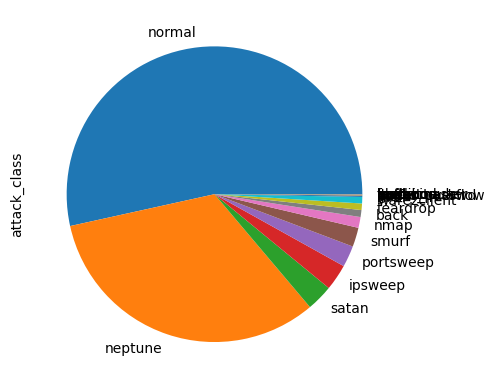

In [4]:
traindf["attack_class"].value_counts().plot.pie()

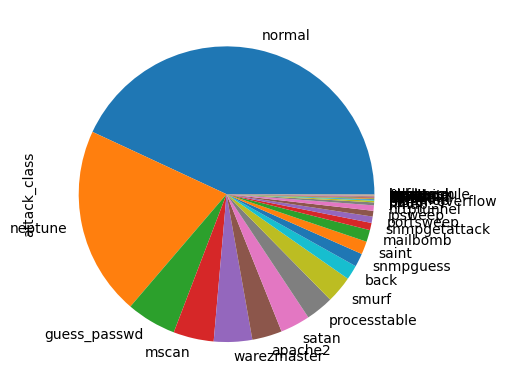

In [5]:
testdf["attack_class"].value_counts().plot.pie()

In [6]:
testdf['label'] = testdf.apply(classLabel,1)
testdf.head()

traindf['label'] = traindf.apply(classLabel,1)
traindf.head()

# add column for binary classification to both datasets

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class,num_learners,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,0


In [7]:
print("mean ",traindf['duration'].mean())
print("std ",traindf['duration'].std())

print("mean ",traindf[traindf['label']==0]['duration'].mean())
print("mean ",traindf[traindf['label']==0]['duration'].std())
print("mean ",traindf[traindf['label']==1]['duration'].mean())
print("mean ",traindf[traindf['label']==1]['duration'].std())

mean  287.1446500440571
std  2604.5153098675896
mean  168.5873958689099
mean  1304.4521272139536
mean  423.3206890670305
mean  3547.6845328084014


In [8]:
# traindf['duration'].plot()

In [9]:
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset

import torch

import numpy as np

from sklearn.preprocessing import OneHotEncoder

In [10]:
def get_encoder(traindf):
  categorical_columns = traindf.iloc[:,:-3].select_dtypes(include=['object']).columns.tolist()
  #Initialize OneHotEncoder
  encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')
  encoder.fit(traindf[categorical_columns])
  return encoder,categorical_columns

def encode_df(encoder, df, categorical_columns):

  # Apply one-hot encoding to the categorical columns
  one_hot_encoded = encoder.transform(df[categorical_columns])

  #Create a DataFrame with the one-hot encoded columns
  #We use get_feature_names_out() to get the column names for the encoded data
  one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names(categorical_columns))

  colNanCounts = one_hot_df.isnull().sum().sum()

  # Concatenate the one-hot encoded dataframe with the original dataframe
  df_encoded = pd.concat([one_hot_df, df], axis=1)

  # Drop the original categorical columns
  df_encoded = df_encoded.drop(categorical_columns, axis=1)

  return df_encoded,colNanCounts

In [11]:
encoder, categorical_columns = get_encoder(traindf=traindf)

train_encoded,train_nan_counts = encode_df(encoder,traindf,categorical_columns)

# train_encoded.head()

print(train_nan_counts)


0


In [12]:
test_encoded,test_nan_counts = encode_df(encoder,testdf,categorical_columns)

print(test_nan_counts)

0


In [13]:
class NslDataSet(Dataset):
  def __init__(self,df):
    # self.input_df = df.iloc[:,:-3]
    # self.label_df = df.iloc[:,-1:]

    self.input_tensor = torch.tensor(df.iloc[:,:-3].values)
    self.label_tensor = torch.tensor(df.iloc[:,-1:].values)

    # print(self.input_tensor.shape)
    # print(self.label_tensor.shape)


  def __len__(self):
    return len(self.input_tensor)
  
  def __getitem__(self, index):
    
    return self.input_tensor[index],self.label_tensor[index]

In [121]:
trainDSet = NslDataSet(train_encoded)
testDSet = NslDataSet(test_encoded)

train_loader = DataLoader(trainDSet, batch_size=1024, shuffle=True)
test_loader = DataLoader(testDSet,batch_size=1,shuffle=False)

numEpochs = 72

In [132]:
layer = torch.nn.Conv1d(1,32,9,dtype=torch.double)
layer2 = torch.nn.Conv1d(32,64,9,dtype=torch.double)

poolingLayer = torch.nn.MaxPool1d(5)

flattenLayer = torch.nn.Flatten()

linearLayer = torch.nn.Linear(128,1,dtype=torch.double)

dropout = torch.nn.Dropout(p=0.253378)

model = torch.nn.Sequential(layer,torch.nn.ReLU(),
                            poolingLayer,
                            layer2,torch.nn.ReLU(),
                            poolingLayer,
                            flattenLayer,
                            linearLayer,dropout,
                            torch.nn.Sigmoid())

lossFcn = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.00005)

model.train(True)

modelPath = "models/run2"

device = torch.device("cuda:0")

model.to(device=device)

Sequential(
  (0): Conv1d(1, 32, kernel_size=(9,), stride=(1,))
  (1): ReLU()
  (2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv1d(32, 64, kernel_size=(9,), stride=(1,))
  (4): ReLU()
  (5): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=128, out_features=1, bias=True)
  (8): Dropout(p=0.253378, inplace=False)
  (9): Sigmoid()
)

In [134]:
for epoch in range(numEpochs):

  runningLoss = 0
  batchNumMax = 0
  

  for batch_num,(trainInput,trainLabel) in enumerate(train_loader):
    
    trainInput = trainInput.to(device)
    trainLabel = trainLabel.to(device)

    optimizer.zero_grad()

    out = model(trainInput.unsqueeze(1))
    loss = lossFcn(out,trainLabel.double())

    loss.backward()

    optimizer.step()

    runningLoss += loss.item()

    batchNumMax += 1

  print("epoch :",epoch,"loss per batch :",runningLoss/batchNumMax, "loss per data point :", runningLoss/len(train_encoded))

  modelFilePath = modelPath+"/" +str(epoch) + ".pt"
  torch.save(model.state_dict(), modelFilePath)

epoch : 0 loss per batch : 1.6512200503244976 loss per data point : 0.001625358499362861
epoch : 1 loss per batch : 1.1904807131025696 loss per data point : 0.0011718353014115617
epoch : 2 loss per batch : 1.177192357403407 loss per data point : 0.0011587550690864113
epoch : 3 loss per batch : 1.1722937569688847 loss per data point : 0.001153933190954742
epoch : 4 loss per batch : 1.2611058471561583 loss per data point : 0.0012413542985192352
epoch : 5 loss per batch : 1.146622566451487 loss per data point : 0.0011286640648391672
epoch : 6 loss per batch : 1.1655767030397337 loss per data point : 0.001147321340104046
epoch : 7 loss per batch : 1.1971536127676108 loss per data point : 0.0011784036895460437
epoch : 8 loss per batch : 1.1444684314307079 loss per data point : 0.0011265436680670284
epoch : 9 loss per batch : 1.1990039513401864 loss per data point : 0.001180225047956174
epoch : 10 loss per batch : 1.1292652137365111 loss per data point : 0.0011115785644807013
epoch : 11 loss

In [135]:
TrainedModel = torch.load("models/run2/47.pt")

model.load_state_dict(TrainedModel)

testSample,testLabel = next(iter(test_loader))

print(testSample.shape)

model.eval()

model.to("cpu")

testOut = model(testSample.unsqueeze(1))

print(testOut)

print(testLabel)


torch.Size([1, 122])
tensor([[0.9872]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)
tensor([[1]])


In [136]:
correct = 0
totalTestSamples = 0
for testBatNum,(testSample,testLabel) in enumerate(test_loader):
  totalTestSamples += 1
  testOut = model(testSample.unsqueeze(1))
  if testOut < 0.5:
    ans = 0
  else:
    ans = 1

  if ans == testLabel.numpy():
    correct += 1

In [137]:
print(correct)
print(totalTestSamples)

print(correct/totalTestSamples)

18267
22544
0.8102821149751597
